In [2]:
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#hacer Grid search y a ver cual es el mínimo de estimators para ahorrar computacion

In [4]:
directorio_base = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # Subir dos directorios
directorio_pkl = os.path.join(directorio_base, "src", "00.data", "clustering")

# Obtener todos los archivos .pkl en el directorio de preprocesado
archivos_pkl = [f for f in os.listdir(directorio_pkl) if f.startswith("df_clustering_") and f.endswith(".pkl")]

# Si no se encuentran archivos .pkl, mostramos un mensaje
if not archivos_pkl:
    print("❌ No se encontraron archivos .pkl en el directorio.")
else:
    df_lista = []

    # Cargar todos los archivos .pkl
    for archivo in archivos_pkl:
        ruta_archivo = os.path.join(directorio_pkl, archivo)
        try:
            with open(ruta_archivo, "rb") as f:
                df_lista.append(pickle.load(f))
                print(f"✅ Archivo cargado correctamente: {archivo}")
        except FileNotFoundError:
            print(f"❌ No se encontró el archivo: {archivo}")
        except Exception as e:
            print(f"❌ Error al cargar {archivo}: {e}")

    # Concatenar todos los DataFrames en uno solo
    if df_lista:
        df = pd.concat(df_lista, ignore_index=True)
        print(f"✅ DataFrame final con {df.shape[0]} filas y {df.shape[1]} columnas")
    else:
        print("❌ No se cargaron DataFrames.")

✅ Archivo cargado correctamente: df_clustering_1.pkl
✅ Archivo cargado correctamente: df_clustering_2.pkl
✅ Archivo cargado correctamente: df_clustering_3.pkl
✅ DataFrame final con 287563 filas y 10 columnas


In [5]:
df.head()

,news_id,meneos,clicks,karma,positive_votes,negative_votes,anonymous_votes,comments,category,cluster
0,4032594,115,651,410,57,1,58,30,Política y Sociedad,1
1,4032568,77,982,362,50,2,27,24,Entretenimiento y Cultura,1
2,4032569,97,761,369,50,0,47,70,Política y Sociedad,1
3,4032482,141,505,352,77,1,64,53,Política y Sociedad,1
4,4032509,213,335,349,99,1,114,28,Política y Sociedad,1


In [6]:
df_clustering = df.drop(columns=['clicks', 'news_id'])

In [7]:
df_clustering

,meneos,karma,positive_votes,negative_votes,anonymous_votes,comments,category,cluster
0,115,410,57,1,58,30,Política y Sociedad,1
1,77,362,50,2,27,24,Entretenimiento y Cultura,1
2,97,369,50,0,47,70,Política y Sociedad,1
3,141,352,77,1,64,53,Política y Sociedad,1
4,213,349,99,1,114,28,Política y Sociedad,1
...,...,...,...,...,...,...,...,...
287558,34,13,34,0,0,0,Humor y Memes,1
287559,61,11,61,0,0,5,Entretenimiento y Cultura,1
287560,267,451,142,0,125,78,Entretenimiento y Cultura,1
287561,121,388,60,2,61,17,Entretenimiento y Cultura,1


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Seleccionar solo las variables numéricas
num_features = ['meneos', 'karma', 'positive_votes', 'anonymous_votes', 'negative_votes', 'comments']

# Convertir a float32 antes de escalar
df_clustering[num_features] = df_clustering[num_features].astype('float32')

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
df_clustering[num_features] = scaler.fit_transform(df_clustering[num_features])

# Guardar el escalador
scaler_path = "../00.data/clustering/scaler.pkl"

with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Aplicar OneHotEncoder a la categoría
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' evita colinealidad
encoded_cats = encoder.fit_transform(df_clustering[['category']])

# Convertir a DataFrame
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(['category']))

# Resetear índice para asegurar alineación antes de la concatenación
df_clustering = df_clustering.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Unir con el dataset original
df_clustering = pd.concat([df_clustering, encoded_df], axis=1)

# Eliminar la columna categórica original
df_clustering.drop(columns=['category'], inplace=True)

# Guardar el encoder
encoder_path = "../00.data/clustering/encoder.pkl"

with open(encoder_path, "wb") as f:
    pickle.dump(encoder, f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
from sklearn.model_selection import train_test_split

# Definir X (features) e y (target)
X = df_clustering.drop(columns=['cluster'])
y = df_clustering['cluster']

# Dividir en entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

In [12]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Ver distribución original de clases
class_counts = Counter(y_train)
print("Distribución original:", class_counts)

# Estrategias de balanceo
smote_strategy = {k: int(v * 1.5) for k, v in class_counts.items() if v < max(class_counts.values())}  # Solo minoritarios
undersample_strategy = {k: int(v * 0.7) for k, v in class_counts.items() if v == max(class_counts.values())}  # Solo mayoritario

# Crear balanceo
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)

# Aplicar solo donde corresponde
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_res, y_train_res = undersample.fit_resample(X_train_smote, y_train_smote)

# Ver nueva distribución de clases
print("Distribución después del balanceo:", Counter(y_train_res))

Distribución original: Counter({1: 187422, 0: 35464, 2: 7164})


C:\Users\Jordi\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Distribución después del balanceo: Counter({1: 131195, 0: 53196, 2: 10746})


C:\Users\Jordi\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\Jordi\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Definir modelo
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Entrenar
rf.fit(X_train_res, y_train_res)

# Evaluar
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

print(classification_report(y_test, y_pred))

# Guardar el modelo
ml_clustering_path = "../00.data/clustering/ml_clustering.pkl"

with open(ml_clustering_path, "wb") as f:
    pickle.dump(rf, f, protocol=pickle.HIGHEST_PROTOCOL)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8866
           1       1.00      0.99      1.00     46856
           2       0.98      0.97      0.97      1791

    accuracy                           0.99     57513
   macro avg       0.98      0.98      0.98     57513
weighted avg       0.99      0.99      0.99     57513



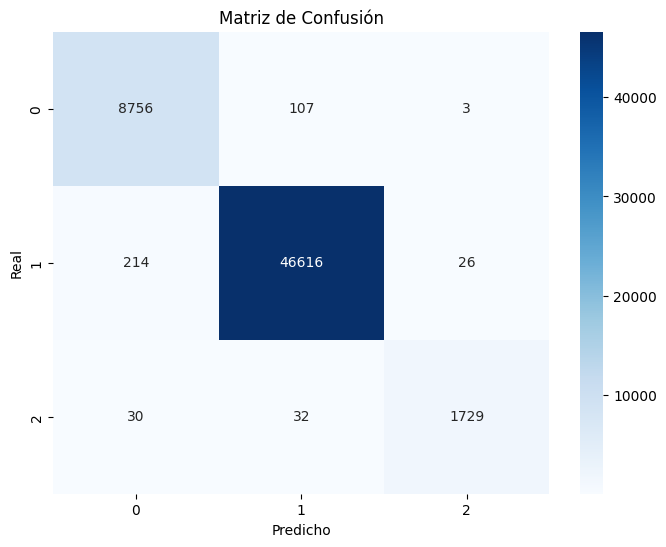

In [14]:
# buscar valores altos fuera de la diagonal. significaría que el modelo se está equivocando más de lo esperado.
from sklearn.metrics import confusion_matrix

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

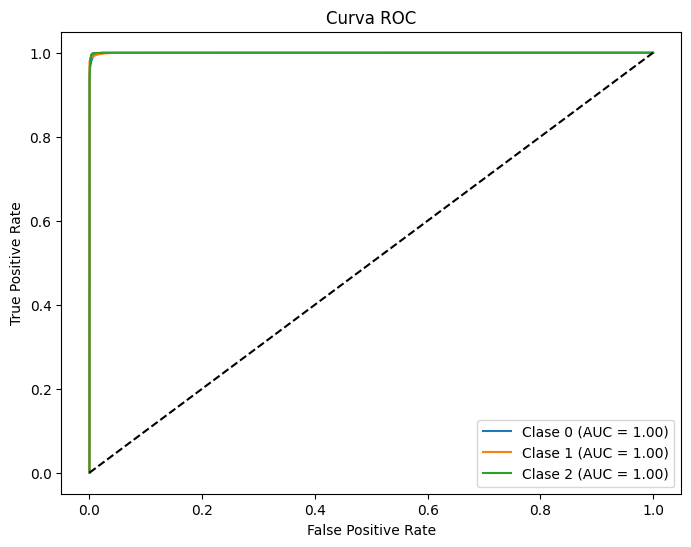

In [15]:
from sklearn.metrics import roc_curve, auc

# Calcular ROC-AUC para cada clase
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(set(y_test))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar
plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

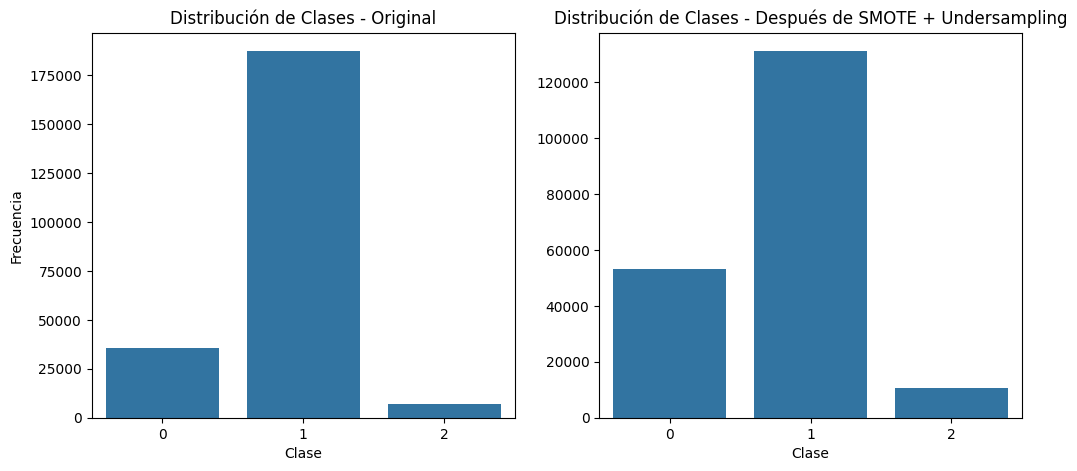

In [16]:
# Comparar distribución de clases original y después del balanceo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), ax=axes[0])
axes[0].set_title("Distribución de Clases - Original")
axes[0].set_xlabel("Clase")
axes[0].set_ylabel("Frecuencia")

# Después de balanceo
balanced_counts = {k: sum(y_train_res == k) for k in set(y_train_res)}
sns.barplot(x=list(balanced_counts.keys()), y=list(balanced_counts.values()), ax=axes[1])
axes[1].set_title("Distribución de Clases - Después de SMOTE + Undersampling")
axes[1].set_xlabel("Clase")

plt.show()

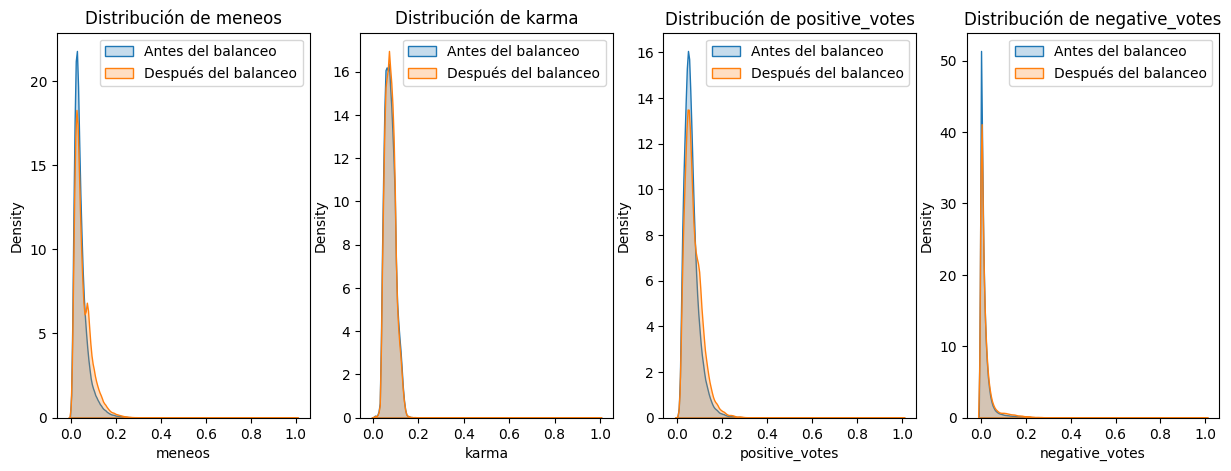

📌 meneos: La media de meneos ha aumentado tras el balanceo.
📌 karma: La media de karma ha aumentado tras el balanceo.
📌 positive_votes: La media de positive_votes ha aumentado tras el balanceo.
📌 negative_votes: La media de negative_votes ha aumentado tras el balanceo.


In [17]:
# Características a visualizar
features_to_check = ['meneos', 'karma', 'positive_votes', 'negative_votes']

# Diccionario para almacenar comentarios automáticos
comments = {}

plt.figure(figsize=(15, 5))
for i, feature in enumerate(features_to_check, 1):
    plt.subplot(1, len(features_to_check), i)
    
    # Graficar la distribución antes y después del balanceo
    sns.kdeplot(X_train[feature], label="Antes del balanceo", fill=True)
    sns.kdeplot(X_train_res[feature], label="Después del balanceo", fill=True)
    
    plt.title(f'Distribución de {feature}')
    plt.legend()

    # Generar comentario automático
    mean_before = X_train[feature].mean()
    mean_after = X_train_res[feature].mean()
    
    if mean_after > mean_before:
        comment = f"La media de {feature} ha aumentado tras el balanceo."
    elif mean_after < mean_before:
        comment = f"La media de {feature} ha disminuido tras el balanceo."
    else:
        comment = f"La media de {feature} se ha mantenido estable tras el balanceo."
    
    comments[feature] = comment

plt.show()

# Mostrar comentarios generados
for feature, comment in comments.items():
    print(f"📌 {feature}: {comment}")

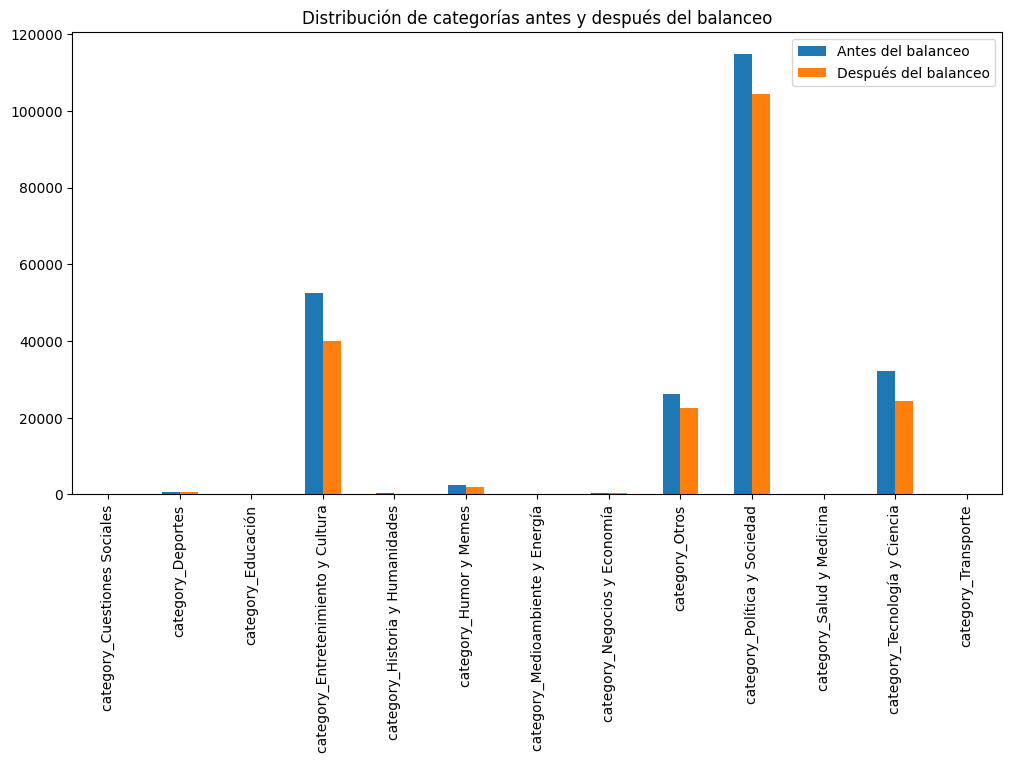

In [18]:
# Contar frecuencia de cada categoría antes y después del balanceo
category_cols = [col for col in X_train.columns if col.startswith("category_")]
category_counts_before = X_train[category_cols].sum()
category_counts_after = X_train_res[category_cols].sum()

# Unir los datos en un DataFrame
df_counts = pd.DataFrame({"Antes del balanceo": category_counts_before, "Después del balanceo": category_counts_after})

# Graficar
df_counts.plot(kind="bar", figsize=(12, 6), title="Distribución de categorías antes y después del balanceo")
plt.xticks(rotation=90)
plt.show()